In [104]:
from itertools import repeat
from multiprocessing import Pool

import censusdata
import censusgeocode as cg
import geopandas
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
from geopy import distance

In [2]:
# Read in the bagel geolocated data

final_bagel_data_geo = pd.read_pickle("final_bagel_data_geo.pkl")

In [3]:
# Use FCC API to extract information for each lat/long and its associated census tract

census_tracts = []

for index, row in final_bagel_data_geo.iterrows():

    lat = pd.to_numeric(row["lat_gmap"])
    lng = pd.to_numeric(row["lng_gmap"])
            url = 'https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}5&format=json'.format(lat,lng)
    response = requests.get(url)
    data = response.json()["Block"]["FIPS"]
    df = pd.DataFrame({"lng_gmap": [lng], "lat_gmap": [lat], "fips": [data]})
    census_tracts.append(df)

In [4]:
# Concat information about census

census_tracts_clean = pd.concat(census_tracts).drop_duplicates()

In [5]:
# Merge the clean census data

final_bagel_data_geo_clean = final_bagel_data_geo.merge(
    census_tracts_clean, on=["lat_gmap", "lng_gmap"], how="left"
)

final_bagel_data_geo_clean[
    "county_tract_bagel"
] = final_bagel_data_geo_clean.fips.str.slice(start=2, stop=11)

In [6]:
# Read in the census tract information and the centroids for each census tract

tract_cen = pd.read_csv(
    "https://www2.census.gov/geo/docs/reference/cenpop2010/tract/CenPop2010_Mean_TR36.txt",
    dtype="object",
)

In [7]:
# Keep only NYC census tracts

tract_cen_nyc = tract_cen[
    tract_cen.COUNTYFP.isin(["005", "047", "061", "081", "085"])
].reset_index(drop=True)
tract_cen_nyc["county_tract"] = tract_cen_nyc["COUNTYFP"] + tract_cen_nyc["TRACTCE"]
tract_cen_nyc["LONGITUDE"] = pd.to_numeric("-" + tract_cen_nyc["LONGITUDE"].str[2:])
tract_cen_nyc["LATITUDE"] = pd.to_numeric(tract_cen_nyc["LATITUDE"])

In [8]:
# Function to find distance to all bagel shops from the centroid of each census tract
# Note, this can be improved, this takes a while to run

tract_cen_bagels = pd.DataFrame()

for tract in tract_cen_nyc.county_tract:
    df = final_bagel_data_geo_clean.copy()
    df["lat_nyc"] = tract_cen_nyc[tract_cen_nyc.county_tract == tract][
        "LATITUDE"
    ].values[0]
    df["lng_nyc"] = tract_cen_nyc[tract_cen_nyc.county_tract == tract][
        "LONGITUDE"
    ].values[0]
    df["county_tract"] = tract
    df["dist"] = df.apply(
        lambda row: distance.distance(
            (row.lat_nyc, row.lng_nyc), (row.lat_gmap, row.lng_gmap)
        ).miles,
        axis=1,
    )

    tract_cen_bagels = tract_cen_bagels.append(df).reset_index(drop=True)

In [141]:
# Save file

tract_cen_bagels.to_pickle("tract_cen_bagels.pkl")
tract_cen_bagels.to_csv("tract_cen_bagels.csv", index=False)

# tract_cen_bagels = pd.read_pickle("tract_cen_bagels.pkl")

In [38]:
tract_cen_bagels.head(2)

,name,phone,review_count,price,food_type,rating,address,town,search,loc,formatted_address_gmap,lat_gmap,lng_gmap,fips,county_tract_bagel,lat_nyc,lng_nyc,county_tract,dist
0,Atlantic Bagel Company,7189345800,1.0,NaN,Bagels,3 star rating,2 Neptune Ave,Brighton Beach,Atlantic Bagel Company 2 Neptune Ave Brighton ...,"[{'address_components': [{'long_name': '2', 's...","2 Neptune Ave, Brooklyn, NY 11235, USA",40.58,-73.95,360470610043000,047061004,40.79,-73.88,005000100,15.02
1,Bagel Nest,7188727545,1.0,NaN,Bagels,4 star rating,1237 Fulton St,Bedford Stuyvesant,Bagel Nest 1237 Fulton St Bedford Stuyvesant,"[{'address_components': [{'long_name': '1237',...","1237 Fulton St, Brooklyn, NY 11216, USA",40.68,-73.95,360470245004001,047024500,40.79,-73.88,005000100,8.61


In [84]:
# Extract the rating

tract_cen_bagels["rating_num"] = (
    tract_cen_bagels["rating"].str.extract("(\d+)").astype("float")
)

In [85]:
# Set any review to NA if review count is less than 5

tract_cen_bagels.loc[tract_cen_bagels["review_count"] < 5, "rating_num"] = np.nan

In [88]:
tract_cen_bagels.head(2)

,name,phone,review_count,price,food_type,rating,address,town,search,loc,formatted_address_gmap,lat_gmap,lng_gmap,fips,county_tract_bagel,lat_nyc,lng_nyc,county_tract,dist,rating_num
0,Atlantic Bagel Company,7189345800,1.0,NaN,Bagels,3 star rating,2 Neptune Ave,Brighton Beach,Atlantic Bagel Company 2 Neptune Ave Brighton ...,"[{'address_components': [{'long_name': '2', 's...","2 Neptune Ave, Brooklyn, NY 11235, USA",40.58,-73.95,360470610043000,047061004,40.79,-73.88,005000100,15.02,NaN
1,Bagel Nest,7188727545,1.0,NaN,Bagels,4 star rating,1237 Fulton St,Bedford Stuyvesant,Bagel Nest 1237 Fulton St Bedford Stuyvesant,"[{'address_components': [{'long_name': '1237',...","1237 Fulton St, Brooklyn, NY 11216, USA",40.68,-73.95,360470245004001,047024500,40.79,-73.88,005000100,8.61,NaN


In [44]:
# Get population estimates from census for 2019

pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.precision", 2)

pop = censusdata.download(
    "acs5",
    2019,
    censusdata.censusgeo([("state", "36"), ("county", "*"), ("tract", "*")]),
    ["B01003_001E", "GEO_ID"],
)
pop = pop[["GEO_ID", "B01003_001E"]].rename(columns={"B01003_001E": "total_pop"})
pop["county_tract"] = pop["GEO_ID"].str.slice(start=11, stop=20)
pop["state_county_tract"] = pop["GEO_ID"].str.slice(start=9, stop=20)
pop_clean = pop.drop(["GEO_ID"], axis=1).reset_index(drop=True)

In [45]:
# Source: https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2019.html
# 2019 file is based on 2010 census

area = pd.read_csv(
    "https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2019_Gazetteer/2019_gaz_tracts_36.txt",
    dtype="object",
    sep="\t",
)

In [93]:
# Combine data to get per capita
# May want to consider not letting manhattan census tracts be assigned any brooklyn or queens bagel shops
# The threshold is is the distanc must be below 0.6 miles

tract_cen_bagels_clean = (
    tract_cen_bagels[
        (tract_cen_bagels.county_tract_bagel == tract_cen_bagels.county_tract)
        | (tract_cen_bagels.dist < 0.6)
    ][["county_tract", "name", "rating_num"]]
    .merge(tract_cen_nyc[["county_tract"]], on="county_tract", how="right")
    .groupby(["county_tract"])
    .agg({"name": "count", "rating_num": "mean"})
    .sort_values(["name"], ascending=False)
    .merge(pop_clean, on="county_tract", how="left")
    .rename(columns={"name": "count_bagel_shops"})
    .merge(
        area[["GEOID", "ALAND_SQMI"]],
        left_on="state_county_tract",
        right_on="GEOID",
        how="left",
    )
    .drop(["GEOID"], axis=1)
)

In [94]:
tract_cen_bagels_clean

,county_tract,count_bagel_shops,rating_num,total_pop,state_county_tract,ALAND_SQMI
0,061005000,19,3.53,4748.0,36061005000,0.064
1,061014602,18,3.06,7831.0,36061014602,0.042
2,061014601,18,3.06,4182.0,36061014601,0.029
3,061014801,18,3.06,2810.0,36061014801,0.02
4,061005800,17,3.19,4315.0,36061005800,0.067
...,...,...,...,...,...,...
2163,047112000,0,NaN,3105.0,36047112000,0.067
2164,047112200,0,NaN,3168.0,36047112200,0.063
2165,047112400,0,NaN,3054.0,36047112400,0.069
2166,047112600,0,NaN,3237.0,36047112600,0.065


In [95]:
# Get the bagel per capita estimates

tract_cen_bagels_clean["bagel_per_capita"] = (
    tract_cen_bagels_clean["count_bagel_shops"]
    / tract_cen_bagels_clean["total_pop"]
    * 1000
)
tract_cen_bagels_clean["bagel_per_capita_sq"] = np.sqrt(
    tract_cen_bagels_clean["bagel_per_capita"]
)

In [96]:
tract_cen_bagels_clean

,county_tract,count_bagel_shops,rating_num,total_pop,state_county_tract,ALAND_SQMI,bagel_per_capita,bagel_per_capita_sq
0,061005000,19,3.53,4748.0,36061005000,0.064,4.00,2.00
1,061014602,18,3.06,7831.0,36061014602,0.042,2.30,1.52
2,061014601,18,3.06,4182.0,36061014601,0.029,4.30,2.07
3,061014801,18,3.06,2810.0,36061014801,0.02,6.41,2.53
4,061005800,17,3.19,4315.0,36061005800,0.067,3.94,1.98
...,...,...,...,...,...,...,...,...
2163,047112000,0,NaN,3105.0,36047112000,0.067,0.00,0.00
2164,047112200,0,NaN,3168.0,36047112200,0.063,0.00,0.00
2165,047112400,0,NaN,3054.0,36047112400,0.069,0.00,0.00
2166,047112600,0,NaN,3237.0,36047112600,0.065,0.00,0.00


<AxesSubplot:>

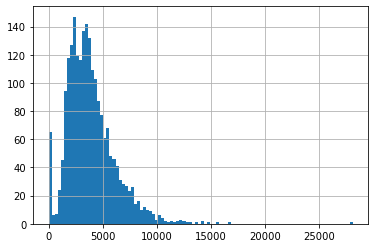

In [97]:
# Look at the distribution of total populations

tract_cen_bagels_clean.total_pop.hist(bins=100)

<AxesSubplot:>

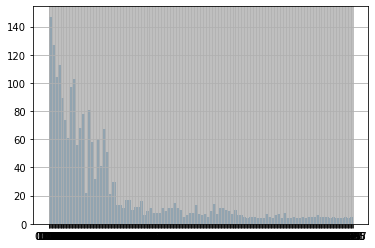

In [98]:
tract_cen_bagels_clean.ALAND_SQMI.hist(bins=100)

In [99]:
# Look at one example of a high bagel shop per capita

tract_cen_bagels[
    (
        (tract_cen_bagels.county_tract_bagel == tract_cen_bagels.county_tract)
        | (tract_cen_bagels.dist < 0.6)
    )
    & (tract_cen_bagels.county_tract == "047054300")
].reset_index()

,index,name,phone,review_count,price,food_type,rating,address,town,search,...,formatted_address_gmap,lat_gmap,lng_gmap,fips,county_tract_bagel,lat_nyc,lng_nyc,county_tract,dist,rating_num
0,480307,Russ & Daughters - Brooklyn,2124754880,63.0,$$,"Bagels, Bakeries, Delis",3 star rating,141 Flushing Ave,,Russ & Daughters - Brooklyn 141 Flushing Ave,...,"141 Flushing Ave Building 77, Brooklyn, NY 112...",40.70,-73.97,360470543001025,047054300,40.7,-73.97,047054300,0.20,3.0
1,480330,Bagel World,7186432686,78.0,$,"Bagels, Breakfast & Brunch",3.5 star rating,223 Dekalb Ave,Fort Greene,Bagel World 223 Dekalb Ave Fort Greene,...,"223 Dekalb Ave, Brooklyn, NY 11205, USA",40.69,-73.97,360470183001002,047018300,40.7,-73.97,047054300,0.52,3.0
2,480337,Myrtle Bagel,7188584916,82.0,$,"Bagels, Sandwiches",3.5 star rating,410 Myrtle Ave,Clinton Hill,Myrtle Bagel 410 Myrtle Ave Clinton Hill,...,"410 Myrtle Ave, Brooklyn, NY 11205, USA",40.69,-73.97,360470195004000,047019500,40.7,-73.97,047054300,0.29,3.0
3,480467,Bergen Bagels,7187899300,232.0,$,"Bagels, Breakfast & Brunch, Sandwiches",3 star rating,536 Myrtle Ave,Clinton Hill,Bergen Bagels 536 Myrtle Ave Clinton Hill,...,"536 Myrtle Ave, Brooklyn, NY 11205, USA",40.69,-73.96,360470193004000,047019300,40.7,-73.97,047054300,0.32,3.0


<AxesSubplot:xlabel='total_pop', ylabel='count_bagel_shops'>

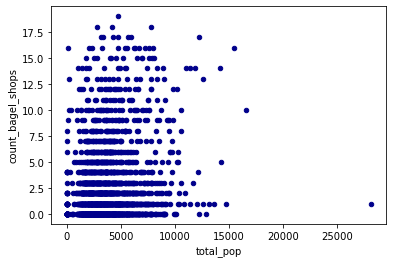

In [100]:
tract_cen_bagels_clean.plot.scatter(y="count_bagel_shops", x="total_pop", c="DarkBlue")

In [101]:
tract_cen_bagels_clean.to_csv("tract_cen_bagels_clean.csv", index=False)

In [105]:
# Data: https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
geojson_nyc = gpd.read_file("2010 Census Tracts.geojson")

In [144]:
tract_cen_bagels_clean['high_rating_flag'] = np.where(tract_cen_bagels_clean.rating_num > 4, '1', '0')

In [146]:
tract_cen_bagels_clean["CT2010"] = tract_cen_bagels_clean.county_tract.str.slice(
    start=3, stop=11
)
tract_cen_bagels_clean["County"] = tract_cen_bagels_clean.county_tract.str.slice(
    start=0, stop=3
)

tract_cen_bagels_clean.loc[tract_cen_bagels_clean.County == "005", "County"] = "2"
tract_cen_bagels_clean.loc[tract_cen_bagels_clean.County == "061", "County"] = "1"
tract_cen_bagels_clean.loc[tract_cen_bagels_clean.County == "047", "County"] = "3"
tract_cen_bagels_clean.loc[tract_cen_bagels_clean.County == "081", "County"] = "4"
tract_cen_bagels_clean.loc[tract_cen_bagels_clean.County == "085", "County"] = "5"
tract_cen_bagels_clean["BoroCT2010"] = (
    tract_cen_bagels_clean["County"] + tract_cen_bagels_clean["CT2010"]
)

In [147]:
tract_cen_bagels_geo = geojson_nyc.merge(
    tract_cen_bagels_clean, left_on="boro_ct2010", right_on="BoroCT2010"
)

In [148]:
tract_cen_bagels_geo.loc[
    tract_cen_bagels_geo.ntaname.str.contains("park-cemetery"), "park_cemetery_flag"
] = 1

In [151]:
tract_cen_bagels_geo.dtypes

ntacode                  object
shape_area               object
ntaname                  object
shape_leng               object
boro_name                object
puma                     object
ct2010                   object
boro_code                object
cdeligibil               object
boro_ct2010              object
ctlabel                  object
geometry               geometry
county_tract             object
count_bagel_shops         int64
rating_num              float64
total_pop               float64
state_county_tract       object
ALAND_SQMI               object
bagel_per_capita        float64
bagel_per_capita_sq     float64
CT2010                   object
County                   object
BoroCT2010               object
high_rating_flag         object
park_cemetery_flag      float64
dtype: object

In [149]:
tract_cen_bagels_geo.head(2)

,ntacode,shape_area,ntaname,shape_leng,boro_name,puma,ct2010,boro_code,cdeligibil,boro_ct2010,...,total_pop,state_county_tract,ALAND_SQMI,bagel_per_capita,bagel_per_capita_sq,CT2010,County,BoroCT2010,high_rating_flag,park_cemetery_flag
0,SI22,2497009.71359,West New Brighton-New Brighton-St. George,7729.01679383,Staten Island,3903,000900,5,E,5000900,...,1510.0,36085000900,0.09,0.66,0.81,000900,5,5000900,0,NaN
1,MN19,1906016.35002,Turtle Bay-East Midtown,5534.19981063,Manhattan,3808,009800,1,I,1009800,...,7302.0,36061009800,0.068,1.37,1.17,009800,1,1009800,0,NaN


In [150]:
tract_cen_bagels_geo.to_csv("tract_cen_bagels_geo.csv", index=False)
tract_cen_bagels_geo.to_file("tract_cen_bagels_geo.json", driver="GeoJSON")